In [48]:
## External Libararies
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [49]:
import torch
import torch.nn as nn
import random

In [50]:
## HyperParameters (Do not adjust for Question 1b)##

n_epoch = 500
n_seed = 5
lr = 1
batch_size = 5000

test_split = 1/6

layer_1_node = 10
layer_2_node = 2

#######################
layer_dims = [layer_1_node, layer_2_node]
seed_values = [random.randint(0, 10000) for _ in range(5)]

In [51]:
def preprocess_data(X, Y, test_split=1/6):
  assert(X.shape[0] == Y.shape[0])
  assert(test_split > 0 and test_split < 1)
  train_size = X.shape[0] * (1-test_split)


  #shuffle data
  #np.random.seed(shuffle_seed)
  ind = np.random.permutation(X.shape[0])
  X_shuff = X[ind]
  Y_shuff = Y[ind]


  def typedPreprocessing(X, type):
    if type == "none":
        return X
    train_means = []
    test_means = []
    for cols in range(X.shape[1]):
      train_means.append(np.mean(X[0:int(train_size), cols]))
      test_means.append(np.mean(X[int(train_size):, cols]))
    if type == "zero_center":
      train_out = []
      test_out = []
      for cols in range(X.shape[1]):
        train_out.append([(x - train_means[cols]) for x in X[0:int(train_size), cols]])
        test_out.append([(x - test_means[cols]) for x in X[int(train_size):, cols]])
      train_out = np.transpose(train_out)
      test_out = np.transpose(test_out)
    elif type == "normalize":
      train_stds = []
      train_out = []
      test_stds = []
      test_out = []
      for cols in range(X.shape[1]):
        train_stds.append(np.std(X[:int(train_size), cols]))
        test_stds.append(np.std(X[int(train_size):, cols]))
        train_out.append([(x - train_means[cols])/train_stds[cols] for x in X[0:int(train_size), cols]])
        test_out.append([(x - test_means[cols])/test_stds[cols] for x in X[int(train_size):, cols]])
      train_out = np.transpose(train_out)
      test_out = np.transpose(test_out)
    return train_out, test_out


  def separateY(Y, test_size):
    y_train = Y[:int(train_size)]
    y_test = Y[int(train_size):]
    return y_train, y_test

  X_train, X_test = typedPreprocessing(X_shuff, "normalize")
  y_train, y_test = separateY(Y_shuff, train_size)

  return torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)

class MLP(nn.Module):
    """
    MLP class to create a multi-layer perceptron dynamically.

    Args:
        input_dim (int): The dimensionality of the input features.
        layers_dims (list of int): A list specifying the number of units in each hidden layer.
        output_dim (int): The dimensionality of the output.
        seed_value (int, optional): Random seed for reproducibility. If this is set to None, no manual seed is set.

    Attributes:
        layers (nn.ModuleList): A ModuleList to hold all the layers including input, hidden and output layers.
    """

    def __init__(self, input_dim, layers_dims, output_dim, seed_value=None):
        """
        Initialize MLP.
        """
        super(MLP, self).__init__()

        ## TODO:

        self.layers = nn.ModuleList()
        # Adding input&hidden layer, each layer with an activation layer by sigmoid
        if len(layers_dims) == 0:
          self.layers.append(nn.Linear(input_dim, output_dim))
        else:
          # Adding input layer
          self.layers.append(nn.Linear(input_dim, layers_dims[0]))
          if len(layers_dims) != 1:
            for i in range(1, len(layers_dims)):
              assert(layers_dims[i] > 0)
              self.layers.append(nn.Linear(layers_dims[i-1], layers_dims[i]))

          # Adding output layer
          self.layers.append(nn.Linear(layers_dims[-1], output_dim))


        self._initialize_weights(seed_value)



    def _initialize_weights(self, seed_value):
        """
        Initialize the weights and biases of the model.
        """

        ## TODO:
        if seed_value != None:
          for layers in self.layers:
            if isinstance(layers, nn.Linear):
                torch.manual_seed(seed_value)
                torch.nn.init.xavier_uniform_(layers.weight)
                torch.manual_seed(seed_value)
                torch.nn.init.normal_(layers.bias)
        else:
          for layers in self.layers:
            if isinstance(layers, nn.Linear):
              torch.nn.init.xavier_uniform_(layers.weight)
              torch.nn.init.normal_(layers.bias)


    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): input tensor.

        Returns:
            torch.Tensor: output tensor.
        """
        # TODO:
        for f in self.layers:
          x = nn.functional.sigmoid(f(x))
        return x


In [52]:
# Reload the data
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/fall23_hw4_prob2_data.npy'
data = np.load(DATA_PATH)

Y = data[:,2]
X = data[:,0:2]

X_train, X_test, y_train, y_test = preprocess_data(X, Y, test_split)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


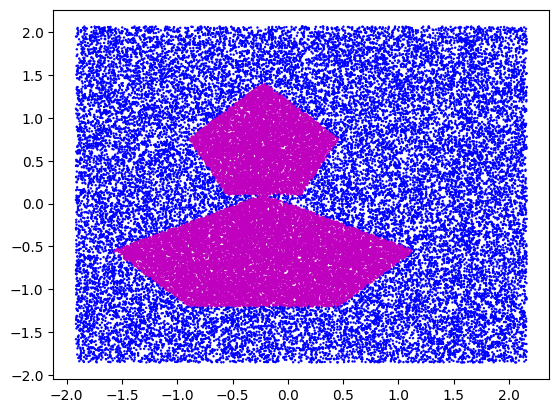

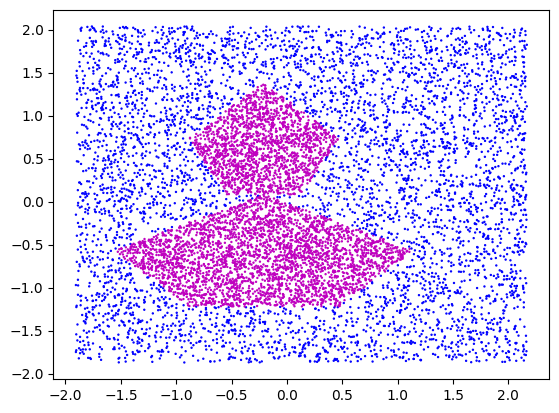

In [53]:
def visualize_datapoints(X, Y):

    assert(X.shape[0] == Y.shape[0])
    fig, ax = plt.subplots()
    npts = 60000
    col = np.where(Y[:npts]==1,'m','b')
    x1 = X[:npts][:,0]
    x2 = X[:npts][:,1]
    ax.scatter(x1, x2, s=0.5, c=col, zorder=1)
    plt.show()

visualize_datapoints(X_train, y_train)
visualize_datapoints(X_test, y_test)

In [54]:
def train(model,
          loss_f,
          optimizer,
          X_train,
          y_train,
          X_test=None,
          y_test=None,
          n_epoch=500,
          batch_size=None,
          seed_value=0):
    """
      The main function for model training.

      Args:
        model (torch.nn.Module): model to train
        loss_f (torch.nn.Module): loss function
        optimizer (torch.optim.Optimizer): optimizer
        X_train, y_train (torch.Tensor): training data
        X_test, y_test (torch.Tensor): test data
        n_epoch (int): number of epochs
        batch_size (int): size of the batch
        seed_value (int): random seed value

      Returns:
        .... (to be added by student)

    """

    # TODO: Complete the train function. You need to implement mini-batch training for this question.
    #
    # Tips: Perform proper sanity checks to ensure your inputs are reasonable. Keep track of important variables
    # (loss, accuracy) throughout the training loop. Print intermediate values reguarly to help you track if
    # your training is working as intended (so that if something is wrong you can terminate the process early
    # instead of going through all 5 runs.)

    # Data loader
    training_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size)

    # Training
    training_loss = []
    testing_acc = []
    for epoch in range(n_epoch):
      loss = 0
      for X_batch, y_batch in training_loader:
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_pred = model(X_batch)[:, 0]
        loss = loss_f(y_pred.double(), y_batch.double())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      training_loss.append(loss.item())
      # Testing
      model.eval()
      with torch.inference_mode():
        x_eval = torch.tensor(X_test, dtype=torch.float32)
        y_eval = torch.round(model(x_eval))
        y_t = torch.tensor(y_test, dtype=torch.float32)
        acc = torch.eq(y_eval.squeeze(), y_t.squeeze()).sum().item()
        testing_acc.append(acc/len(X_test))
      if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{n_epoch}], train Loss: {training_loss[-1]:.4f},  test accuracy: {testing_acc[-1]:.4f}')


    return training_loss, testing_acc, model

In [55]:
# TODO: complete the cell

## Iterate over Random Initializations
loss_list = []
acc_list = []
model_list = []


for idx in range(len(seed_values)):
    seed_value = seed_values[idx]
    print("~~ Beginning run {} with seed value {} ~~".format(idx, seed_value))
    model = MLP(2, [10,2], 1, seed_value)
    loss, acc, trained_model = train(model, nn.BCELoss(), torch.optim.SGD(model.parameters(), lr=lr), X_train, y_train,
          X_test, y_test, n_epoch, batch_size, seed_value)
    loss_list.append(loss)
    acc_list.append(acc)
    model_list.append(trained_model)


~~ Beginning run 0 with seed value 3660 ~~


<ipython-input-54-50708b47df1a>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
<ipython-input-54-50708b47df1a>:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-54-50708b47df1a>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(y_test, dtype=torch.float32)


Epoch [0/500], train Loss: 0.6919,  test accuracy: 0.5806
Epoch [50/500], train Loss: 0.4086,  test accuracy: 0.8157
Epoch [100/500], train Loss: 0.2036,  test accuracy: 0.9360
Epoch [150/500], train Loss: 0.1383,  test accuracy: 0.9499
Epoch [200/500], train Loss: 0.1017,  test accuracy: 0.9656
Epoch [250/500], train Loss: 0.0739,  test accuracy: 0.9739
Epoch [300/500], train Loss: 0.0604,  test accuracy: 0.9777
Epoch [350/500], train Loss: 0.0533,  test accuracy: 0.9800
Epoch [400/500], train Loss: 0.0491,  test accuracy: 0.9805
Epoch [450/500], train Loss: 0.0461,  test accuracy: 0.9803
~~ Beginning run 1 with seed value 1226 ~~
Epoch [0/500], train Loss: 0.6911,  test accuracy: 0.5953
Epoch [50/500], train Loss: 0.2519,  test accuracy: 0.9224
Epoch [100/500], train Loss: 0.1585,  test accuracy: 0.9496
Epoch [150/500], train Loss: 0.1441,  test accuracy: 0.9513
Epoch [200/500], train Loss: 0.1328,  test accuracy: 0.9537
Epoch [250/500], train Loss: 0.1134,  test accuracy: 0.9592
Epo

In [56]:
# Statistics:
final_loss = []
final_acc = []

for element in loss_list:
  final_loss.append(element[-1])
for element in acc_list:
  final_acc.append(element[-1])

def describeResults(name, arr, seeds):
  mean = np.mean(arr)
  std = np.std(arr)
  num = len(arr)

  print("The results of " + name + " and their corresponding seeds are: ")
  print(arr)
  print(seeds)
  print("There are %2d results, mean = %5.6f, std = %5.6f"% (num, mean, std))

describeResults("loss", final_loss, seed_values)
describeResults("acc", final_acc,seed_values)

The results of loss and their corresponding seeds are: 
[0.043881471884229674, 0.04845056016600893, 0.08643570911327858, 0.059574835271294195, 0.08195801781814992]
[3660, 1226, 181, 2768, 113]
There are  5 results, mean = 0.064060, std = 0.017274
The results of acc and their corresponding seeds are: 
[0.9806, 0.9831, 0.9733, 0.9751, 0.9712]
[3660, 1226, 181, 2768, 113]
There are  5 results, mean = 0.976660, std = 0.004484


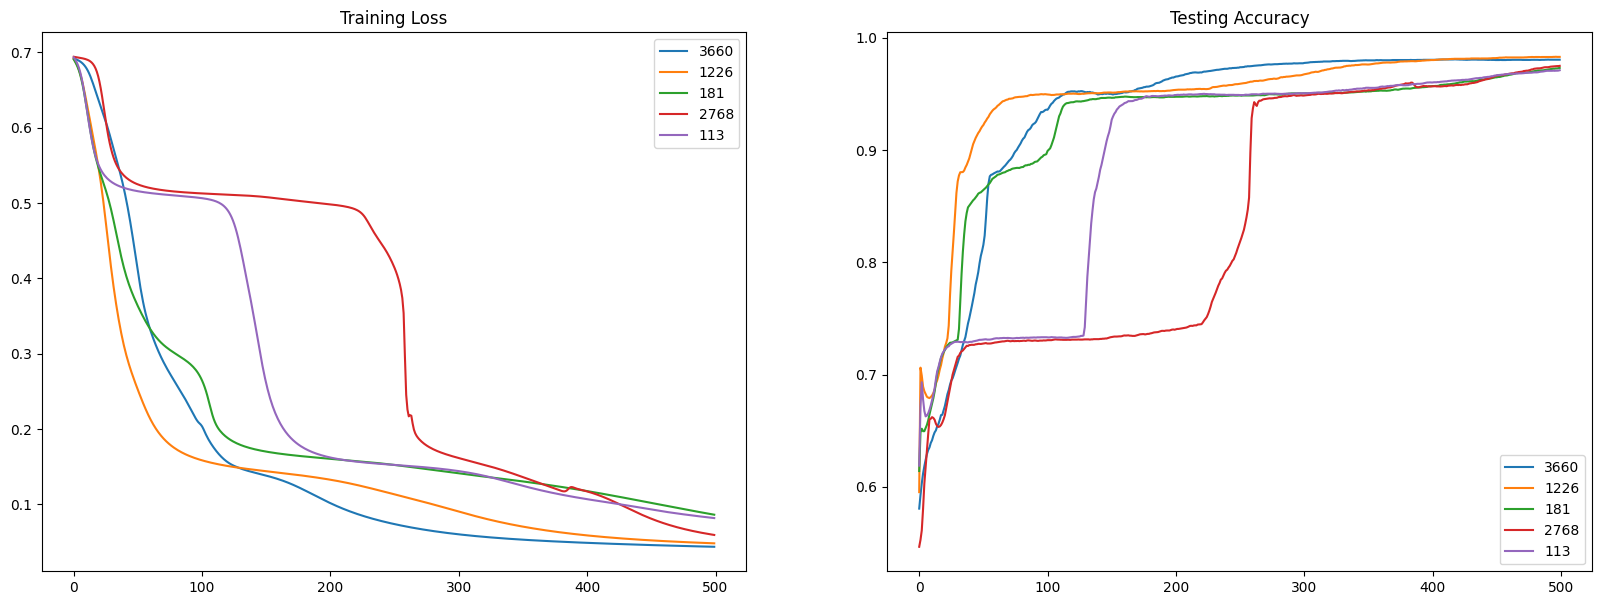

In [57]:
# TODO: Plot Results (Please plot the loss of all 5 runs in a same figure, and
# the accuracy of the runs in another figure). Use visualize_datapoints to check
# the performance of your model.
epochs = [*range(0, 500, 1)]

fig, axs = plt.subplots(1, 2,figsize=(20, 7))
for losses in loss_list:
  axs[0].plot(epochs, losses)
axs[0].set_title('Training Loss')
axs[0].legend(seed_values)
for accs in acc_list:
  axs[1].plot(epochs, accs)
axs[1].set_title('Testing Accuracy')
axs[1].legend(seed_values)


plt.show()

<ipython-input-59-f58b1a071abc>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(X_test[i], dtype=torch.float32)


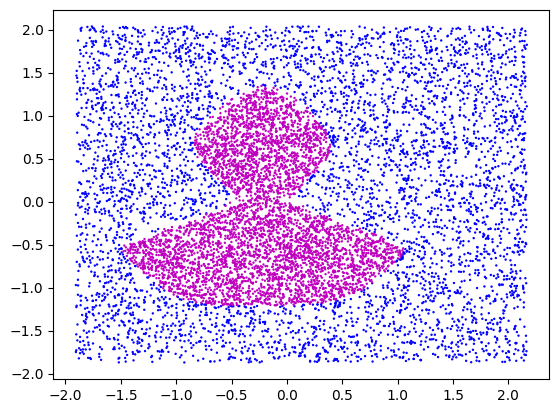

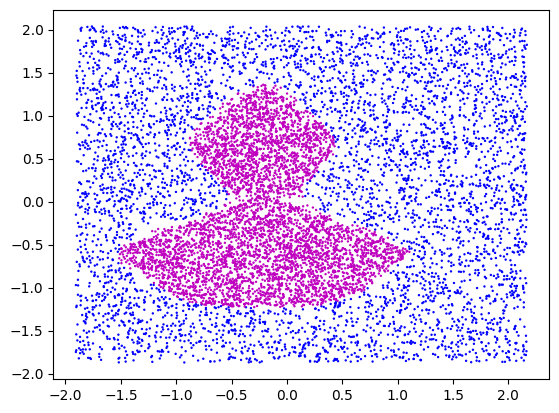

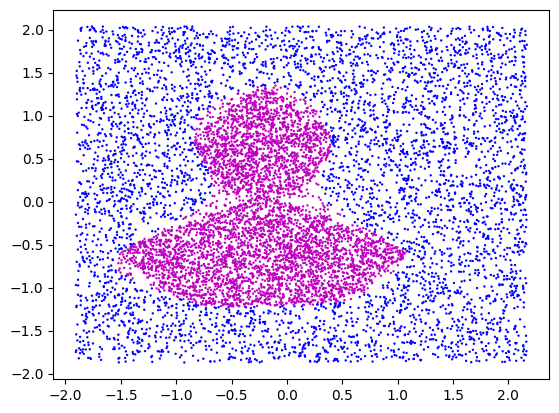

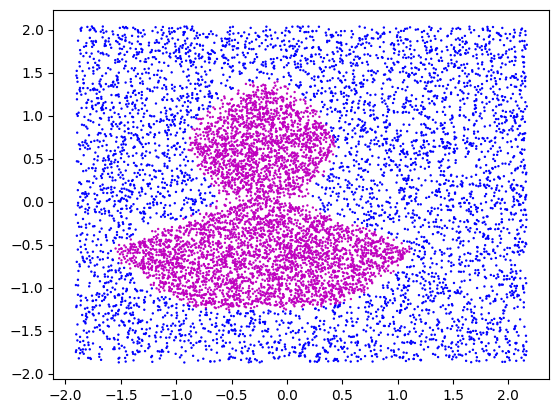

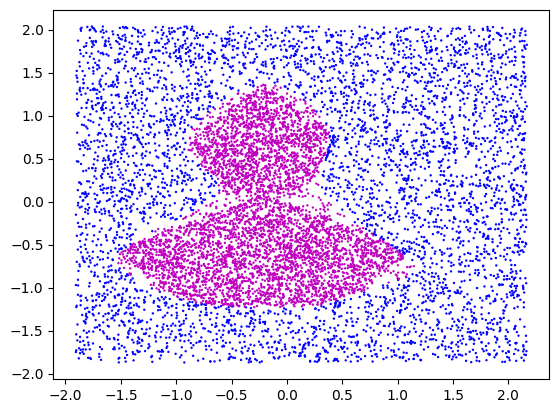

In [59]:

for mods in model_list:
  pred_Y = []
  for i in range(len(X_test)):
    x_in = torch.tensor(X_test[i], dtype=torch.float32)
    pred_Y.append(mods(x_in).round().item())
  visualize_datapoints(X_test, np.array(pred_Y))



In [61]:
# Problem 1c: make adjustments to the layers, and then re-run the training loop with 5 runs and visualizations

## Hyperparameters

n_epoch = 500
n_seed = 5
lr = 1
batch_size = 5000

test_split = 1/6

layer_dims = []

##########################
seed_values = [random.randint(0, 10000) for _ in range(5)]

# Wider hidden layer
loss_list = []
acc_list = []
model_list = []

for idx in range(len(seed_values)):
    seed_value = seed_values[idx]
    print("~~ Beginning run {} with seed value {} ~~".format(idx, seed_value))
    model = MLP(2, [40,20,8], 1, seed_value)
    loss, acc, trained_model = train(model, nn.BCELoss(), torch.optim.SGD(model.parameters(), lr=lr), X_train, y_train,
          X_test, y_test, n_epoch, batch_size, seed_value)
    loss_list.append(loss)
    acc_list.append(acc)
    model_list.append(trained_model)



~~ Beginning run 0 with seed value 6527 ~~


<ipython-input-54-50708b47df1a>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
<ipython-input-54-50708b47df1a>:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-54-50708b47df1a>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(y_test, dtype=torch.float32)


Epoch [0/500], train Loss: 0.6946,  test accuracy: 0.5015
Epoch [50/500], train Loss: 0.5290,  test accuracy: 0.7262
Epoch [100/500], train Loss: 0.3149,  test accuracy: 0.8764
Epoch [150/500], train Loss: 0.2082,  test accuracy: 0.9312
Epoch [200/500], train Loss: 0.1574,  test accuracy: 0.9476
Epoch [250/500], train Loss: 0.1394,  test accuracy: 0.9476
Epoch [300/500], train Loss: 0.1221,  test accuracy: 0.9541
Epoch [350/500], train Loss: 0.1027,  test accuracy: 0.9643
Epoch [400/500], train Loss: 0.0871,  test accuracy: 0.9700
Epoch [450/500], train Loss: 0.0754,  test accuracy: 0.9733
~~ Beginning run 1 with seed value 3710 ~~
Epoch [0/500], train Loss: 0.6934,  test accuracy: 0.5453
Epoch [50/500], train Loss: 0.4941,  test accuracy: 0.7307
Epoch [100/500], train Loss: 0.3172,  test accuracy: 0.8750
Epoch [150/500], train Loss: 0.1884,  test accuracy: 0.9432
Epoch [200/500], train Loss: 0.1551,  test accuracy: 0.9500
Epoch [250/500], train Loss: 0.1454,  test accuracy: 0.9490
Epo

In [62]:
# Statistics:
final_loss = []
final_acc = []

for element in loss_list:
  final_loss.append(element[-1])
for element in acc_list:
  final_acc.append(element[-1])

def describeResults(name, arr, seeds):
  mean = np.mean(arr)
  std = np.std(arr)
  num = len(arr)

  print("The results of " + name + " and their corresponding seeds are: ")
  print(arr)
  print(seeds)
  print("There are %2d results, mean = %5.6f, std = %5.6f"% (num, mean, std))

describeResults("loss", final_loss, seed_values)
describeResults("acc", final_acc,seed_values)

The results of loss and their corresponding seeds are: 
[0.0670551434835993, 0.06378871648513322, 0.06125706727313048, 0.07836562043093466, 0.08027216052554231]
[6527, 3710, 6111, 1112, 305]
There are  5 results, mean = 0.070148, std = 0.007734
The results of acc and their corresponding seeds are: 
[0.9757, 0.9772, 0.9776, 0.9701, 0.9721]
[6527, 3710, 6111, 1112, 305]
There are  5 results, mean = 0.974540, std = 0.002948


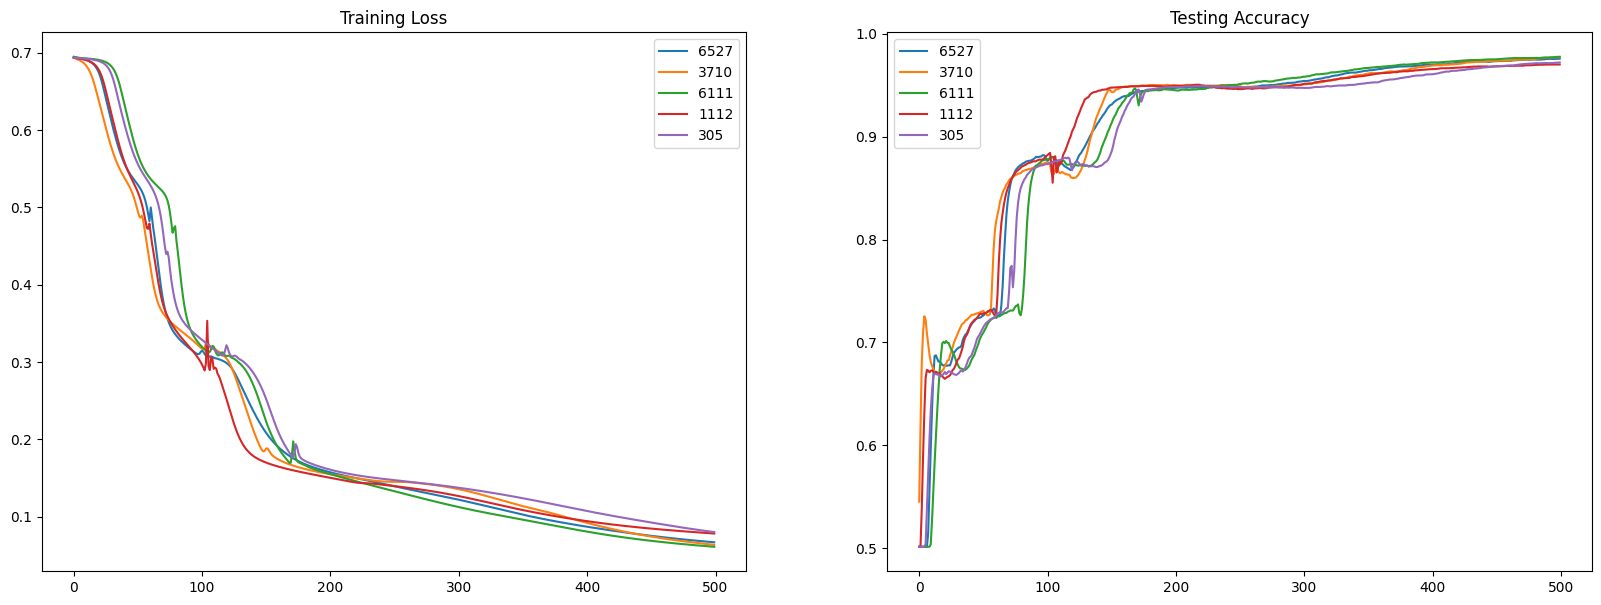

In [63]:
# TODO: Plot Results (Please plot the loss of all 5 runs in a same figure, and
# the accuracy of the runs in another figure). Use visualize_datapoints to check
# the performance of your model.
epochs = [*range(0, 500, 1)]

fig, axs = plt.subplots(1, 2,figsize=(20, 7))
for losses in loss_list:
  axs[0].plot(epochs, losses)
axs[0].set_title('Training Loss')
axs[0].legend(seed_values)
for accs in acc_list:
  axs[1].plot(epochs, accs)
axs[1].set_title('Testing Accuracy')
axs[1].legend(seed_values)


plt.show()

<ipython-input-64-f58b1a071abc>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(X_test[i], dtype=torch.float32)


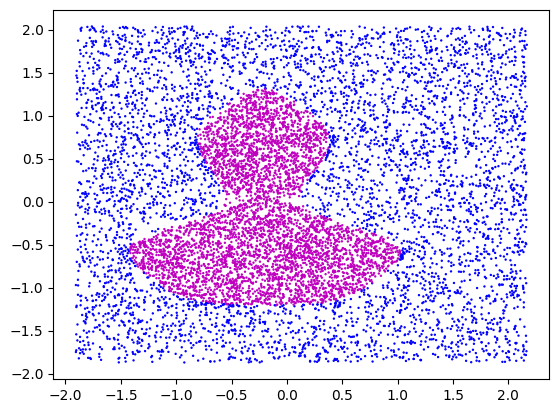

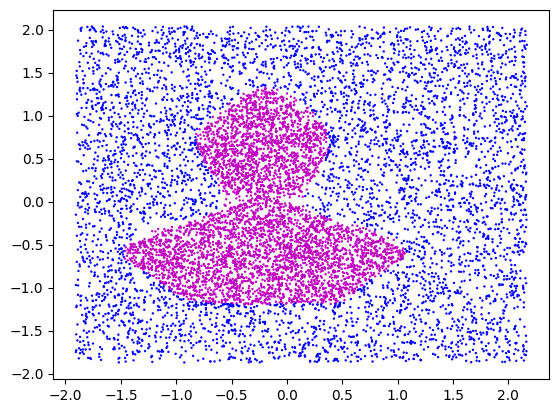

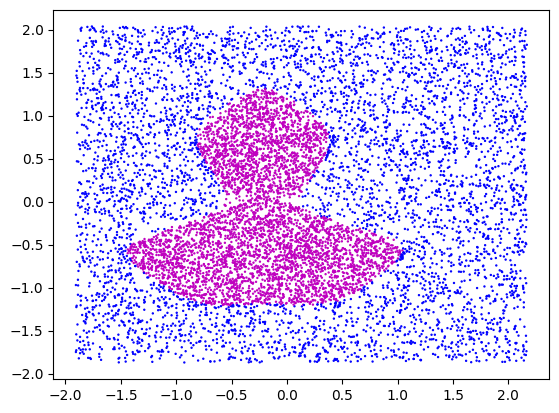

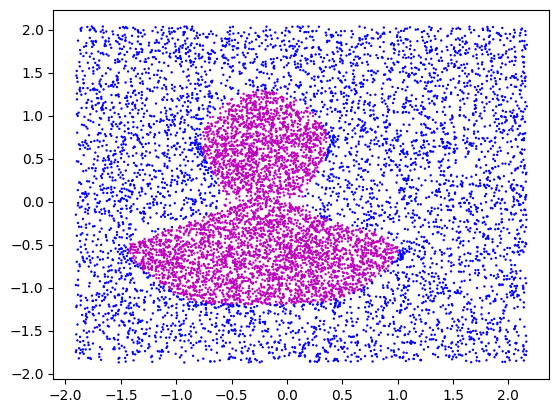

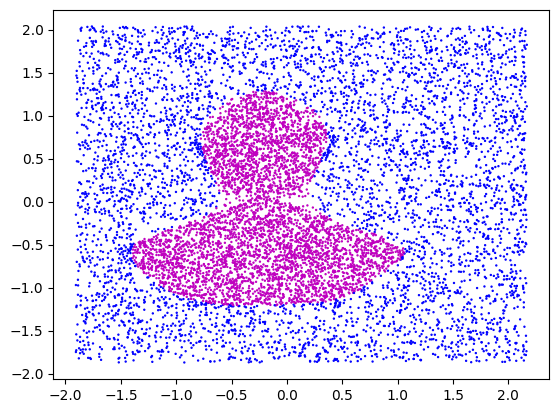

In [64]:

for mods in model_list:
  pred_Y = []
  for i in range(len(X_test)):
    x_in = torch.tensor(X_test[i], dtype=torch.float32)
    pred_Y.append(mods(x_in).round().item())
  visualize_datapoints(X_test, np.array(pred_Y))



# **Waste**

In [ ]:
# TODO: complete the cell

## Iterate over Random Initializations
loss_list = []
acc_list = []
model_list = []


for idx in range(len(seed_values)):
    seed_value = seed_values[idx]
    print("~~ Beginning run {} with seed value {} ~~".format(idx, seed_value))
    model = MLP(2, [10,2], 1, seed_value)
    loss, acc, trained_model = train(model, nn.BCELoss(), torch.optim.SGD(model.parameters(), lr=lr), X_train, y_train,
          X_test, y_test, n_epoch, batch_size, seed_value)
    loss_list.append(loss)
    acc_list.append(acc)
    model_list.append(trained_model)


~~ Beginning run 0 with seed value 9597 ~~


<ipython-input-13-949b8e8396f0>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
<ipython-input-13-949b8e8396f0>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval = torch.tensor(torch.from_numpy(X_test), dtype=torch.float32)
<ipython-input-13-949b8e8396f0>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(torch.from_numpy(y_test), dtype=torch.float32)


0
loss
[0.6003591033841225]
acc
[0.4977497749774977]
50
loss
[0.6003591033841225, 0.6811951445872563, 0.6842004320221271, 0.6841358074219177, 0.6839372930658457, 0.6837073468246573, 0.6834428028136563, 0.6831343057352479, 0.6827690365363155, 0.6823294862128617, 0.6817921797897695, 0.6811234112374018, 0.6802757220314285, 0.6791793839093505, 0.6777315576098314, 0.6757785832160942, 0.673091634825089, 0.6693377695399106, 0.6640604358252321, 0.6567046119000228, 0.6467190578349039, 0.6337114873388472, 0.6175661263051827, 0.598527547612393, 0.5772875943125813, 0.5549540910808173, 0.5328004023197412, 0.5119219665173654, 0.4930058114584052, 0.4763018888868439, 0.461740704144789, 0.44908136085180994, 0.43801755380719376, 0.42823416196665715, 0.41943870894109925, 0.41138098851498417, 0.4038626254937431, 0.3967390096198139, 0.38991447137586094, 0.38333293493217846, 0.3769673816465502, 0.37080892903778107, 0.3648599835685681, 0.3591263517233377, 0.3536109572122461, 0.348310131475305, 0.343212277653

In [ ]:
# Statistics:
final_loss = []
final_acc = []

for element in loss_list:
  final_loss.append(element[-1])
for element in acc_list:
  final_acc.append(element[-1])

def describeResults(name, arr, seeds):
  mean = np.mean(arr)
  std = np.std(arr)
  num = len(arr)

  print("The results of " + name + " and their corresponding seeds are: ")
  print(arr)
  print(seeds)
  print("There are %2d results, mean = %5.6f, std = %5.6f"% (num, mean, std))

describeResults("loss", final_loss, seed_values)
describeResults("acc", final_acc,seed_values)

NameError: ignored

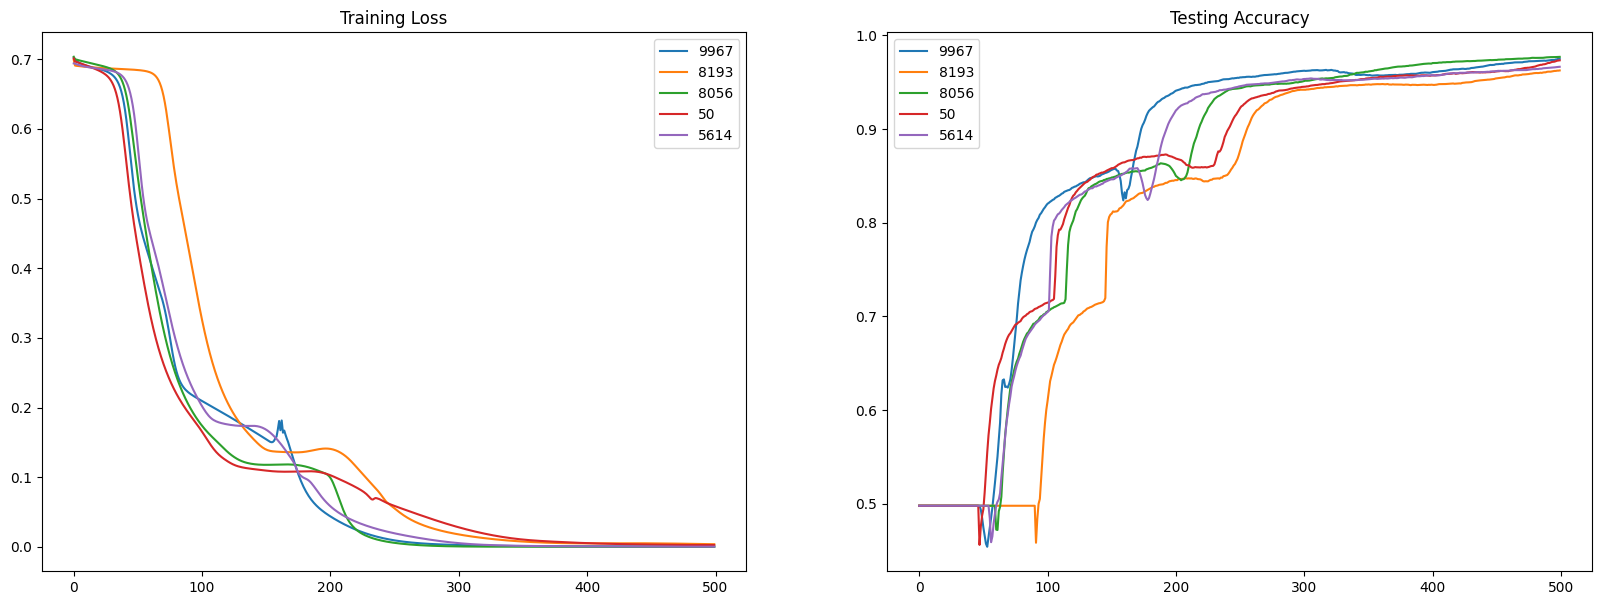

In [ ]:
# TODO: Plot Results (Please plot the loss of all 5 runs in a same figure, and
# the accuracy of the runs in another figure). Use visualize_datapoints to check
# the performance of your model.
epochs = [*range(0, 500, 1)]

fig, axs = plt.subplots(1, 2,figsize=(20, 7))
for losses in loss_list:
  axs[0].plot(epochs, losses)
axs[0].set_title('Training Loss')
axs[0].legend(seed_values)
for accs in acc_list:
  axs[1].plot(epochs, accs)
axs[1].set_title('Testing Accuracy')
axs[1].legend(seed_values)


plt.show()

<ipython-input-16-eda47a688656>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(torch.from_numpy(X_test[i]), dtype=torch.float32)


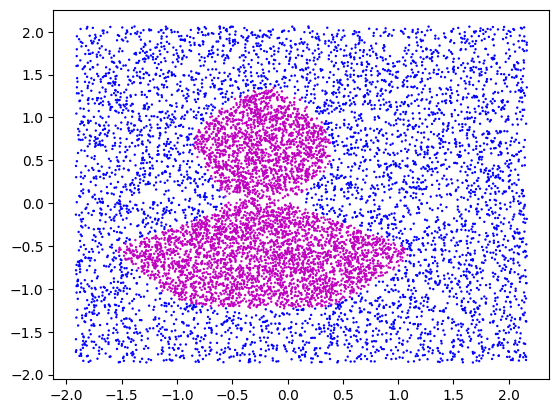

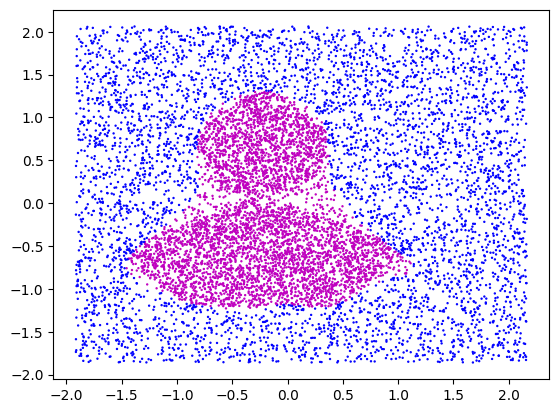

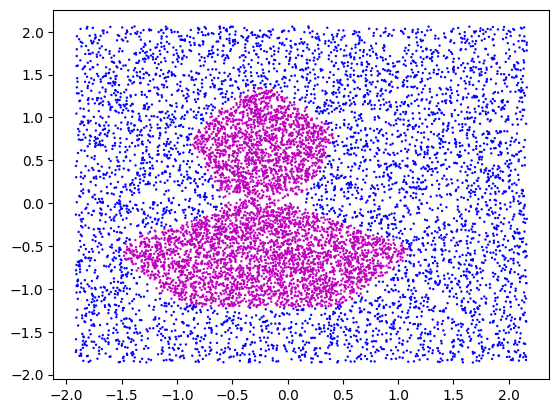

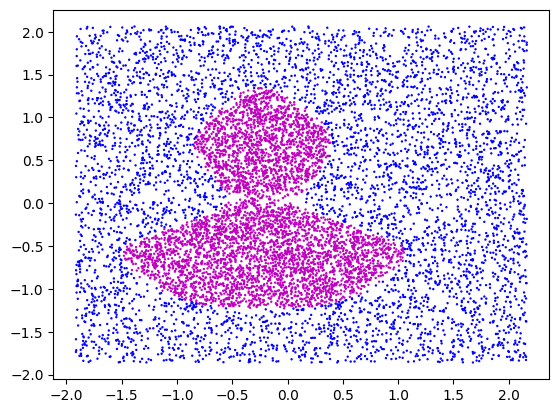

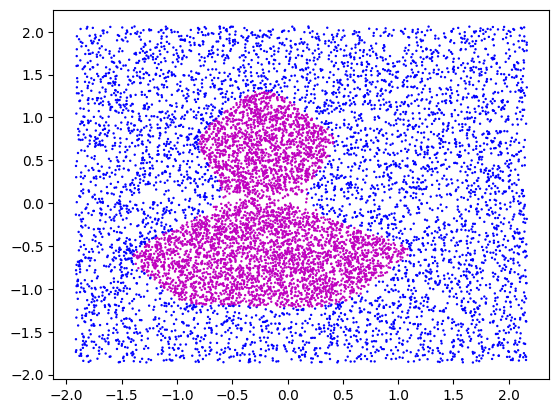

In [ ]:

for mods in model_list:
  pred_Y = []
  for i in range(len(X_test)):
    x_in = torch.tensor(torch.from_numpy(X_test[i]), dtype=torch.float32)
  visualize_datapoints(X_test, np.array(pred_Y))


In [ ]:
# Problem 1c: make adjustments to the layers, and then re-run the training loop with 5 runs and visualizations

## Hyperparameters

n_epoch = 500
n_seed = 5
lr = 1
batch_size = 5000

test_split = 1/6

layer_dims = []

##########################
seed_values = [random.randint(0, 10000) for _ in range(5)]

# Wider hidden layer
loss_list = []
acc_list = []
model_list = []

for idx in range(len(seed_values)):
    seed_value = seed_values[idx]
    print("~~ Beginning run {} with seed value {} ~~".format(idx, seed_value))
    model = MLP(2, [40,20,8], 1, seed_value)
    loss, acc, trained_model = train(model, nn.BCELoss(), torch.optim.SGD(model.parameters(), lr=lr), X_train, y_train,
          X_test, y_test, n_epoch, batch_size, seed_value)
    loss_list.append(loss)
    acc_list.append(acc)
    model_list.append(trained_model)



~~ Beginning run 0 with seed value 4540 ~~


<ipython-input-52-949b8e8396f0>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
<ipython-input-52-949b8e8396f0>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval = torch.tensor(torch.from_numpy(X_test), dtype=torch.float32)
<ipython-input-52-949b8e8396f0>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(torch.from_numpy(y_test), dtype=torch.float32)


0
loss
[0.7025318421571]
acc
[0.4977497749774977]
50
loss
[0.7025318421571, 0.7001639615684824, 0.6990703159478417, 0.6980402758189681, 0.6970639521278535, 0.6961362864716738, 0.6952529632883409, 0.6944102851077875, 0.6936046912460067, 0.6928326367189219, 0.6920904123425519, 0.6913740252312369, 0.6906790798600296, 0.6900008973393472, 0.6893343967831104, 0.6886734432592788, 0.6880114438224786, 0.6873404600277432, 0.6866519234877723, 0.6859348047186576, 0.6851766886975822, 0.6843617754633183, 0.6834713142350061, 0.6824810334663814, 0.6813611875721552, 0.680073971923581, 0.678570747815918, 0.6767909190232695, 0.6746581389866333, 0.6720780159917938, 0.6689374763586565, 0.6651055977372636, 0.6604366465941669, 0.6547779520494268, 0.6479781493909275, 0.6399023269569891, 0.6304528726190723, 0.6196053530552801, 0.6074486476445131, 0.5942135205829164, 0.5802632298815913, 0.5660346651178533, 0.5519518879202534, 0.538344893709297, 0.5254087249370438, 0.5132084839235986, 0.5017103421608431, 0.49081

In [ ]:
# Statistics:
final_loss = []
final_acc = []

for element in loss_list:
  final_loss.append(element[-1])
for element in acc_list:
  final_acc.append(element[-1])

def describeResults(name, arr, seeds):
  mean = np.mean(arr)
  std = np.std(arr)
  num = len(arr)

  print("The results of " + name + " and their corresponding seeds are: ")
  print(arr)
  print(seeds)
  print("There are %2d results, mean = %5.6f, std = %5.6f"% (num, mean, std))

describeResults("loss", final_loss, seed_values)
describeResults("acc", final_acc,seed_values)

The results of loss and their corresponding seeds are: 
[6.669425540849628e-05, 0.000864908389648816, 8.410641821947261e-05, 0.0002118693992537131, 0.0013966559280418538]
[4540, 8672, 9868, 5453, 868]
There are  5 results, mean = 0.000525, std = 0.000525
The results of acc and their corresponding seeds are: 
[0.9743974397439744, 0.9724972497249725, 0.9664966496649665, 0.9747974797479748, 0.9536953695369537]
[4540, 8672, 9868, 5453, 868]
There are  5 results, mean = 0.968377, std = 0.007919


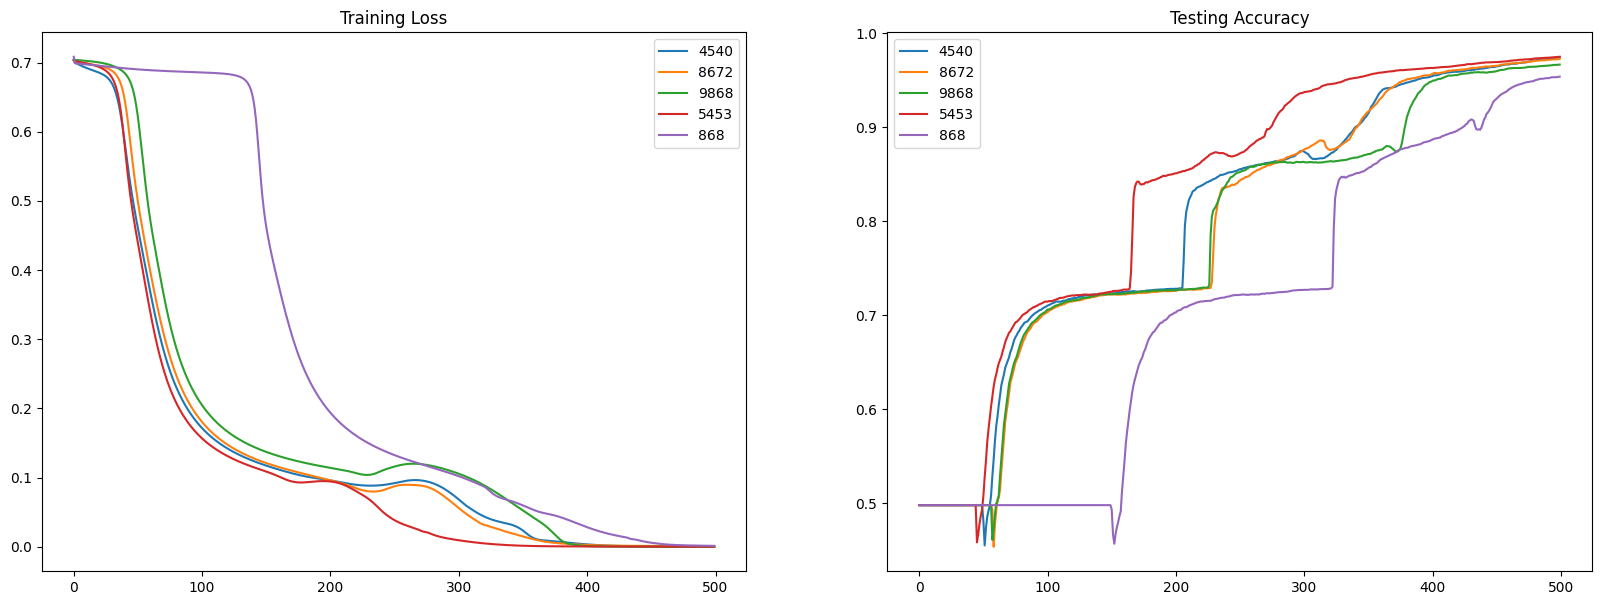

In [ ]:
epochs = [*range(0, 500, 1)]

fig, axs = plt.subplots(1, 2,figsize=(20, 7))
for losses in loss_list:
  axs[0].plot(epochs, losses)
axs[0].set_title('Training Loss')
axs[0].legend(seed_values)
for accs in acc_list:
  axs[1].plot(epochs, accs)
axs[1].set_title('Testing Accuracy')
axs[1].legend(seed_values)


plt.show()

<ipython-input-75-a727653a237b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(torch.from_numpy(X_test[i]), dtype=torch.float32)


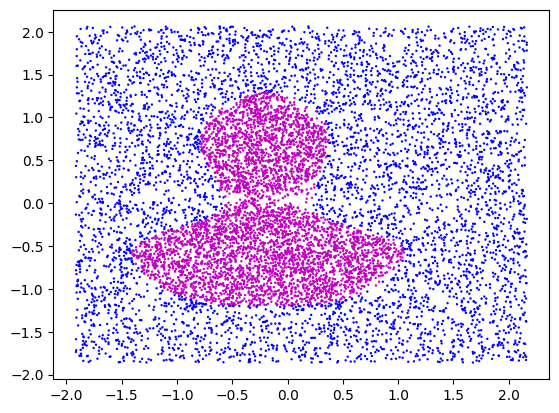

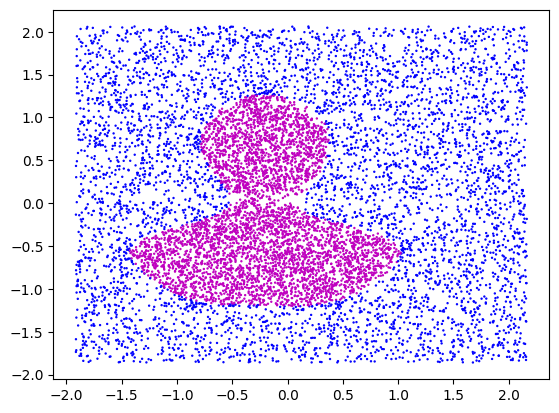

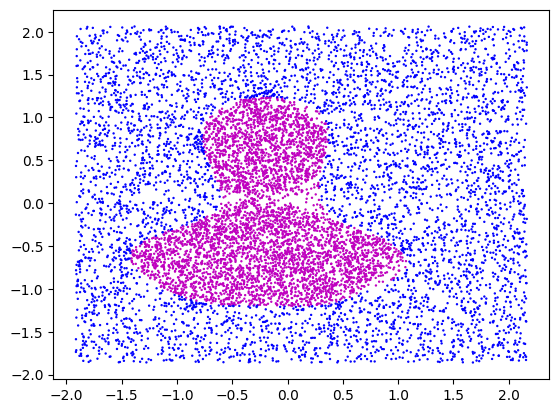

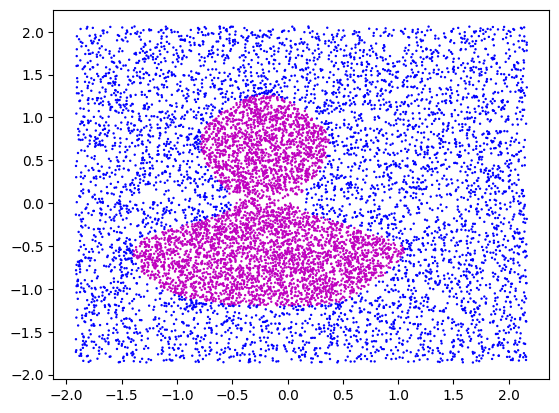

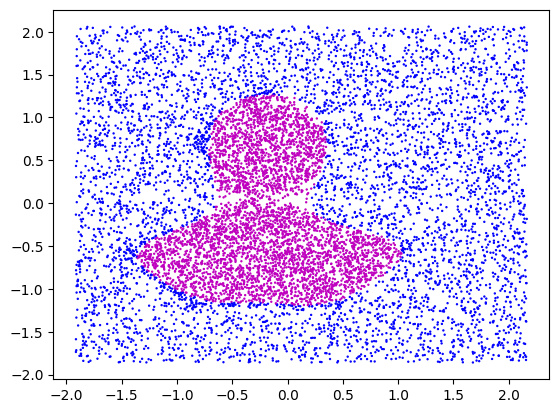

In [ ]:
for mods in model_list:
  pred_Y = []
  for i in range(len(X_test)):
    x_in = torch.tensor(torch.from_numpy(X_test[i]), dtype=torch.float32)
    pred_Y.append(mods(x_in).round().item())
  visualize_datapoints(X_test, np.array(pred_Y))